**Here  i would start from the cleaned data as i have merged by data sets for comparison while working on the eda section. I am going to show which model works better as compared to other models and this Jupyter notebook is going to show the detailed steps needed to accomplish the task. Which is which model works good and which model does not and if  the model overfits or underfitts also**

## Modeling and Prediction

Project 4: Group exercise

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
np.random.seed(42)
import re
from sklearn import svm
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as cm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation,metrics

from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})

# setting visual

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
% load_ext giphy_magic
%matplotlib inline

/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
 

In [2]:
prediction_data=pd.read_csv('./assets/prediction_data1.csv')

In [3]:
working_data=pd.read_csv('./assets/working_data1.csv')

In [4]:
# train, test=train_test_split(working_data, test_size=.20, random_state=42)

In [5]:
#confirming that the number of rows/observations is still the same
working_data.shape, prediction_data.shape

((10506, 41), (116293, 39))

In [6]:
#assert working_data.isnull().sum().sum() == 0 # Never hurts to check again for null values.

In [7]:
working_data.tail(1)

,Unnamed: 0,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,DewPointcl,Trange,SatT
10505,10505,2013-09-26,"4200 West 65th Street, Chicago, IL 60621, USA",CULEX PIPIENS/RESTUANS,42,W 65TH ST,T235,"4200 W 65TH ST, Chicago, IL",41.776428,-87.627096,...,0.0,0.0,29.34,30.04,3.8,8,4.2,0,25.0,11.0


In [8]:
prediction_data.tail(1)

,Unnamed: 0,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,DewPointcl,Trange,SatT
116292,116292,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",CULEX ERRATICUS,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.63359,...,0.0,0.32,29.03,29.78,7.2,17,7.9,0,9.0,7.0


In [9]:
working_data.columns

Index(['Unnamed: 0', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Hour', 'Week', 'Month', 'Year', 'Day',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'DewPointcl', 'Trange', 'SatT'],
      dtype='object')

In [10]:
prediction_data.columns

Index(['Unnamed: 0', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Hour', 'Month', 'Year', 'Day', 'Week', 'Station', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'DewPointcl',
       'Trange', 'SatT'],
      dtype='object')

In [11]:
print(working_data.shape, prediction_data.shape)

(10506, 41) (116293, 39)


In [12]:
# # calculating Baseline
## Check for baseline. 

baseline = len(working_data[working_data['WnvPresent'] == 0]['WnvPresent']) / float(len(working_data))
1- baseline

0.05244622120692932

### 2. Feature Engineering
These features didn't improve predictive scores, and were not used in the final model:

In [13]:
# #get dummy variables for only for mosquito species that have Wnv 
prediction_data_species = pd.get_dummies(prediction_data['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]
working_data_species = pd.get_dummies(working_data['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]
                                                      

In [14]:
working_data.columns

Index(['Unnamed: 0', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Hour', 'Week', 'Month', 'Year', 'Day',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'DewPointcl', 'Trange', 'SatT'],
      dtype='object')

In [15]:
prediction_data.columns

Index(['Unnamed: 0', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Hour', 'Month', 'Year', 'Day', 'Week', 'Station', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'DewPointcl',
       'Trange', 'SatT'],
      dtype='object')

In [16]:
#adding to pipiens/restauns, so it can maybe learn from those, since those are the ones that carry wnv?
#so it makes it extra sensitive?

new_species = []
for i in prediction_data['Species']:
    if i == 'UNSPECIFIED CULEX':
        new_species.append('CULEX PIPIENS/RESTUANS')
    else:
        new_species.append(i)
prediction_data['Species'] = new_species

In [17]:
prediction_data['Species'].value_counts()

CULEX PIPIENS/RESTUANS    29704
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
CULEX ERRATICUS           14345
Name: Species, dtype: int64

In [18]:
working_data['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [19]:
# To get  the missing zipcodes, maybe calculate based on lat/long?
# i tried it but i did not see its relevance

import re
zipcodes = []
for i in working_data['Address']:
    reg = re.compile('\d{5}')
    zipcodes.append(reg.findall(i)) 
#working_data['Zipcode'] = zipcodes

zipcodes2 = []
for i in prediction_data['Address']:
    reg = re.compile('\d{5}')
    zipcodes2.append(reg.findall(i)) 
#prediction_data['Zipcode'] = zipcodes2

In [20]:
# working_data.drop(columns=['WetBulb'], axis=1, inplace=True)

working_data = pd.get_dummies(working_data, columns=['Species'], drop_first=True)

prediction_data.drop(columns=['Unnamed: 0','AddressNumberAndStreet','Date',
                        'Latitude', 'Longitude','Address','CodeSum'], axis=1, inplace=True)

prediction_data = pd.get_dummies(prediction_data, columns=['Species'], drop_first=True)

In [21]:
working_data.columns

Index(['Unnamed: 0', 'Date', 'Address', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Hour', 'Week', 'Month', 'Year', 'Day',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'DewPointcl', 'Trange', 'SatT', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS'],
      dtype='object')

In [22]:
working_data.drop(columns=['Unnamed: 0','Address','Date', 'Street', 'Trap','AddressNumberAndStreet','CodeSum','WetBulb',
                          'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum','Depart', 'DewPoint', 'Depth', 'SnowFall','PrecipTotal', 
                           'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir','AvgSpeed', 'DewPointcl', 'Trange',
                           'SatT'], axis =1, inplace =True)

In [23]:
prediction_data.columns

Index(['Block', 'Street', 'Trap', 'AddressAccuracy', 'Hour', 'Month', 'Year',
       'Day', 'Week', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'DewPointcl', 'Trange', 'SatT', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS'],
      dtype='object')

In [24]:
prediction_data.drop(columns=['Street', 'Trap','WetBulb','Heat', 'Cool', 'Sunrise',
                              'Sunset', 'Depart', 'DewPoint','Depth', 'SnowFall','PrecipTotal',
                              'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir','AvgSpeed', 
                              'DewPointcl', 'Trange','SatT'], axis =1, inplace =True)

In [25]:
working_data.shape, prediction_data.shape

((10506, 21), (116293, 17))

#### 3. Model Building 

I was working on Each of these models were gird searched manually to find the best hyper-parameters, then the best scoring output  will be submitted to Kaggle based on David Beron and Harsha decisions

In [26]:
# working_data[columns] = working_data.columns.apply(lambda x: float(x.split()[0].replace(',', '')))
# prediction_data[columns] = prediction_data.columns.apply(lambda x: float(x.split()[0].replace(',', '')))

In [27]:
# #making sure index is in order
# prediction_data = prediction_data.sort_values(by=['Id'])

In [28]:
target = working_data.WnvPresent
features = working_data.drop(columns=['WnvPresent', "NumMosquitos"])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    stratify=target,
                                                    random_state=42)

In [30]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


In [31]:
from sklearn.preprocessing import scale
X_test = scale(X_test)

In [32]:
# Define X and y variables, train test split, convert into dense matrix (preffered xgboost inputs)

X = working_data.drop('WnvPresent', 1)
y = working_data.WnvPresent

X_train, X_test, y_train, y_test = train_test_split(X, y)

D_xgb_mat_working_data = xgb.DMatrix(X_train, y_train)
D_xgb_mat_ = xgb.DMatrix(X_test, y_test)

In [33]:
## Grid Search Max Depth and Min Child Weight

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)

In [34]:
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [35]:
optimized_GBM.grid_scores_

/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.83494, std: 0.00994, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.83598, std: 0.01104, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.83551, std: 0.01083, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.82042, std: 0.01589, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.81968, std: 0.01676, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.82266, std: 0.01688, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.81777, std: 0.01346, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.81584, std: 0.01780, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.81795, std: 0.01739, params: {'max_depth': 7, 'min_child_weight': 5}]

In [36]:
# Best Scores
optimized_GBM.best_params_

{'max_depth': 3, 'min_child_weight': 3}

In [37]:
# Grid search learning rate and subsample

cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [38]:
optimized_GBM.grid_scores_

/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.83476, std: 0.00963, params: {'learning_rate': 0.1, 'subsample': 0.7},
 mean: 0.83494, std: 0.00994, params: {'learning_rate': 0.1, 'subsample': 0.8},
 mean: 0.83716, std: 0.01105, params: {'learning_rate': 0.1, 'subsample': 0.9},
 mean: 0.86738, std: 0.00730, params: {'learning_rate': 0.01, 'subsample': 0.7},
 mean: 0.86709, std: 0.00810, params: {'learning_rate': 0.01, 'subsample': 0.8},
 mean: 0.86757, std: 0.00812, params: {'learning_rate': 0.01, 'subsample': 0.9}]

In [39]:
# Best Grid Search results

optimized_GBM.best_params_

{'learning_rate': 0.01, 'subsample': 0.9}

In [40]:
# Use parameters from grid search to define our parameters to train our data

our_params = {'eta': 0.1, 'silent':0, 'subsample': 0.9, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1,
             'learning_rate':0.1} 

# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = D_xgb_mat_working_data, num_boost_round = 3000, nfold = 5, 
                metrics = ['auc'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [41]:
# Optimal number of boosting rounds. Does not carry much efficacy, but is supposed to help against overfitting. 
# Did not use because it did not seem to help my score

cv_xgb.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
97,0.913802,0.001371,0.870194,0.009794
98,0.914099,0.001431,0.870390,0.009814
99,0.914485,0.001474,0.870434,0.009812
100,0.914862,0.001505,0.870419,0.009539
101,0.915238,0.001492,0.870458,0.009278


In [42]:
# Train our data

final_gb = xgb.train(our_params, D_xgb_mat_working_data, num_boost_round = 20)

In [43]:
#Predict training set
X_test_predprob = final_gb.predict(D_xgb_mat_)

In [44]:
print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, X_test_predprob))

AUC Score (Test): 0.863849


/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


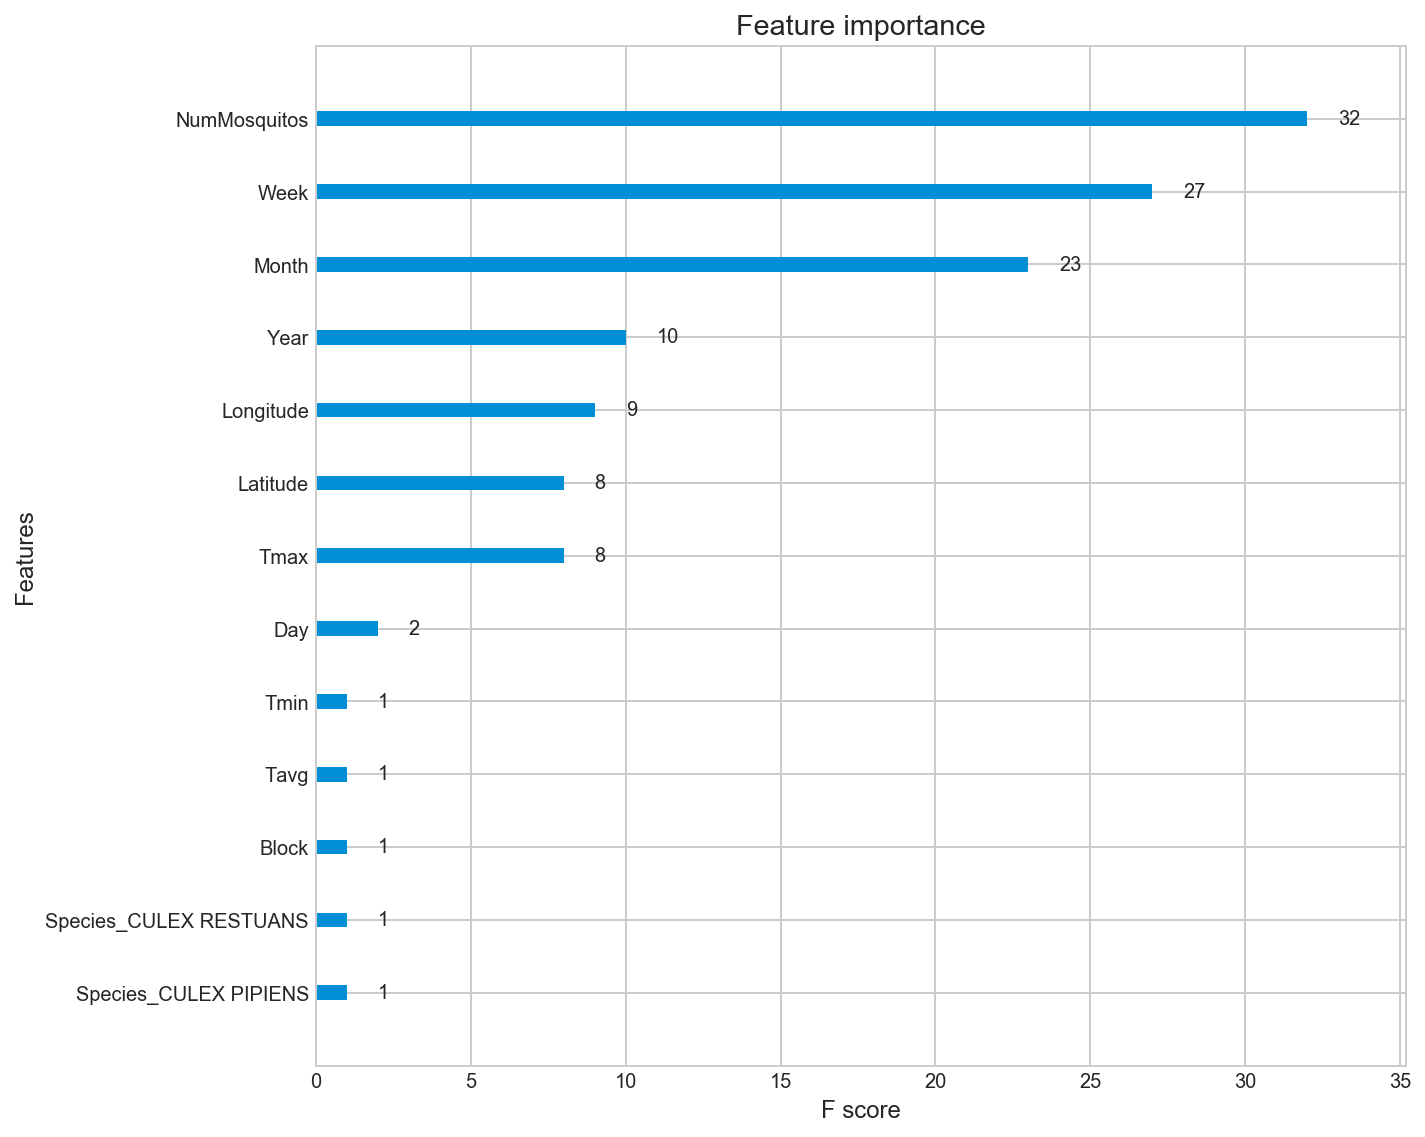

In [45]:
rcParams['figure.figsize'] = 10, 8
xgb.plot_importance(final_gb)

# Plot feature importance

In [46]:
importances = final_gb.get_fscore()
importances

{'NumMosquitos': 32,
 'Year': 10,
 'Species_CULEX PIPIENS': 1,
 'Species_CULEX RESTUANS': 1,
 'Week': 27,
 'Month': 23,
 'Tmax': 8,
 'Latitude': 8,
 'Longitude': 9,
 'Day': 2,
 'Block': 1,
 'Tavg': 1,
 'Tmin': 1}

/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


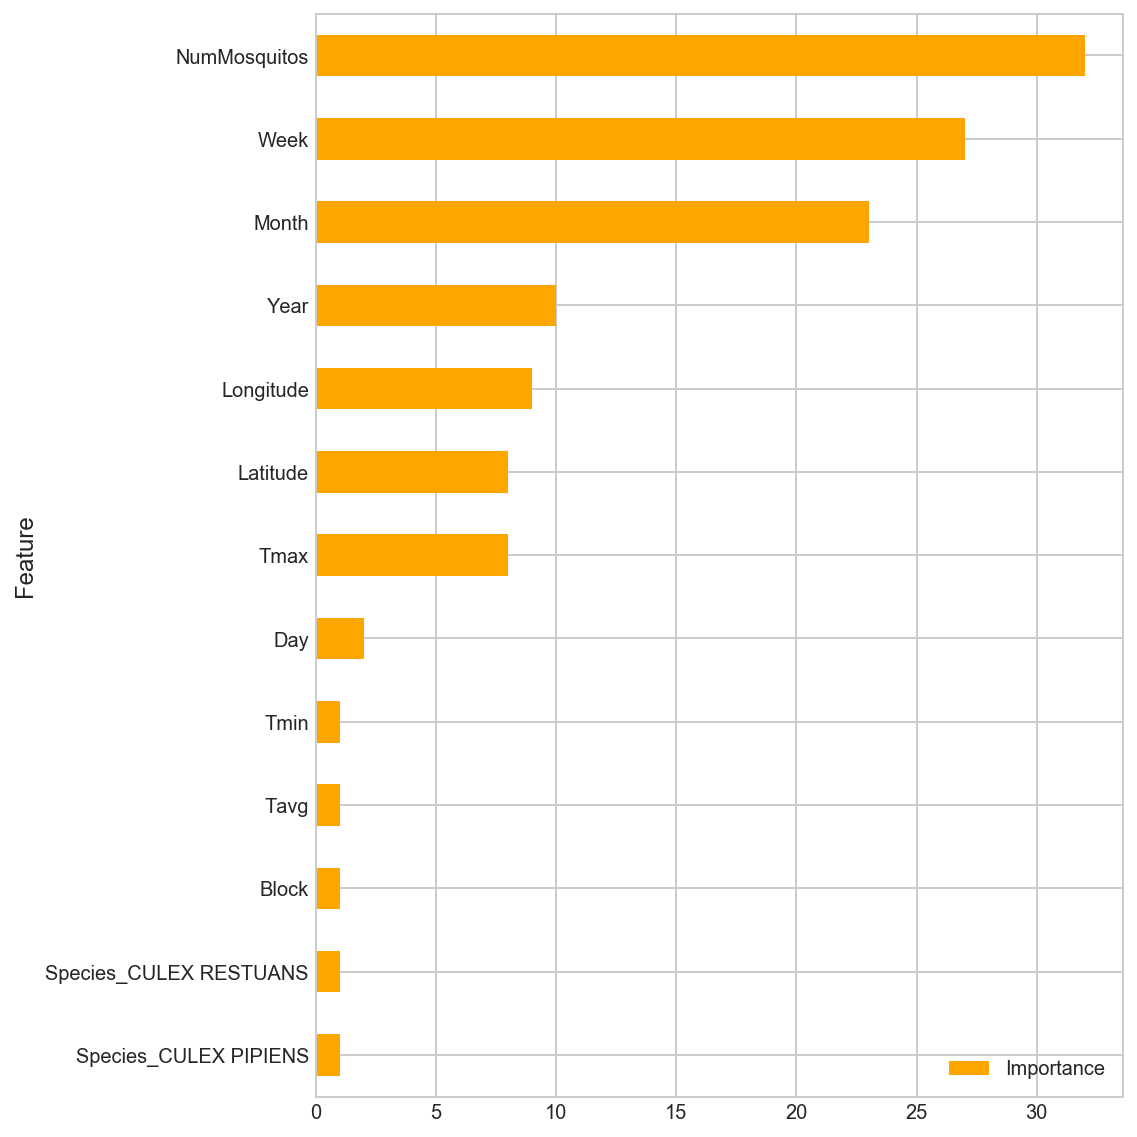

In [47]:
# Plot features in a different style

importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')



In [48]:
D_xgb_test = xgb.DMatrix(X_test)
D_xgb_untest = xgb.DMatrix(X_test)

In [49]:
#Predict training set:
X_test_predprob = final_gb.predict(D_xgb_test)
print(X_test_predprob)

[0.06828458 0.25459436 0.07989744 ... 0.174178   0.14226216 0.06828458]


In [50]:
# Export predictions to CSV

predictions = final_gb.predict(D_xgb_test)

sample = pd.DataFrame(predictions, columns=['WnvPresent'])
sample['Id'] = (sample.index + 1)

sample.to_csv('AUC_Grid_num_beat_the_benchmark_unbalanced_XGB.csv', index=False)



In [51]:
sample

,WnvPresent,Id
0,0.068285,1
1,0.254594,2
2,0.079897,3
3,0.068285,4
4,0.068285,5
5,0.076173,6
6,0.089058,7
7,0.068912,8
8,0.101587,9
9,0.075696,10


In [52]:
wnv = working_data[working_data['WnvPresent'] == 0]
w1nv = working_data[working_data['WnvPresent'] == 1]

In [53]:
print ('total', len(working_data))
print ('No wnv', len(wnv))
print ('wnv', len(w1nv))

total 10506
No wnv 9955
wnv 551


In [54]:
def bootstrap_sample(sample, n=100, replicate = False, size=100):
    ''' Generates bootstrap samples and bootstrap replicates. 
    Bootstrap sample size defaults to 100. 
    Returns bootstrap samples unless replicate function supplied.'''
        
    bootstraps = [list(np.random.choice(sample, size = size)) for i in range(n)]
    
    if replicate == False:
        return(bootstraps)
    else:
        return(list(map(replicate, bootstraps)))

##### Repeating the above process after checking the existance of Data gap

In [55]:
target = working_data.WnvPresent
features = working_data.drop(columns=['WnvPresent', "NumMosquitos"])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    stratify=target,
                                                    random_state=42)

In [57]:
working_data.WnvPresent.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [58]:
# using SMOTE to achieve a better ratio of wnv. SMOTE is a synthetic data bootstrapping.
# ratio 0.5 will set the data to be a 66% original data to 34% new data.
sm = SMOTE(random_state=42, ratio='auto')

X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

from collections import Counter

print(Counter(y_train_res).keys()) # 0 = Wnv not present, 1 = Wnv present.
print(Counter(y_train_res).values()) # The values represent the keys respectively.

dict_keys([1, 0])
dict_values([7466, 7466])


In [59]:
# Ustandardization and applying all models at once
ss  = StandardScaler()

logreg = LogisticRegression()
rfc = RandomForestClassifier(n_estimators=14, random_state=42)
adb = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [60]:
# making pipeline for choosing best model
pipe_logreg = Pipeline([
    ('ss', ss),
    ('logreg', logreg)
])
pipe_rfc = Pipeline([
    ('ss', ss),
    ('rfc', rfc),
])
pipe_adb = Pipeline([
    ('ss', ss),
    ('adb', adb)
])

In [61]:
# # what are the best parameters that would predict wnv

# grid_logreg = GridSearchCV(estimator=pipe_logreg,
#                         param_grid=params_logreg,
#                         scoring='roc_auc',
#                         cv=5)
# grid_rfc = GridSearchCV(estimator=pipe_rfc,
#                         param_grid=params_rfc,
#                         scoring='roc_auc',
#                         cv=5)
# grid_adb = GridSearchCV(estimator=pipe_adb,
#                         param_grid=params_adb,
#                         scoring='roc_auc',
#                         cv=5)

In [62]:
%%time
pipes    = [ 
    pipe_logreg, 
    pipe_rfc, 
    pipe_adb,
]
pipe_idx = {0: 'Logistic Regression', 
            1: 'Random Forest', 
            2: 'Adaboost'
           }

for idx, pipe in enumerate(pipes):
    pipe.fit(X_train_res, y_train_res)
    print('\nScore Train/Test: %s' % pipe_idx[idx])
    print(pipe.score(X_train, y_train))
    print(pipe.score(X_test, y_test))
#     print('Best params: %s' % pipe.best_params_)


Score Train/Test: Logistic Regression
0.6625206244447265
0.6688237533307956

Score Train/Test: Random Forest
0.9729661124508187
0.9219642177388656

Score Train/Test: Adaboost
0.7678639421246352
0.7742672249714503
CPU times: user 2.38 s, sys: 37.5 ms, total: 2.42 s
Wall time: 2.69 s


In [63]:
feat = pipe_rfc.named_steps['rfc']

importance = feat.feature_importances_

# Daylight and months correlate to being the most important features.  Clearly based on time of year
# In addition with latitude and longitude to target the specific
sorted(list(zip(importance, features.keys())), reverse=True)

[(0.1439739681792844, 'Week'),
 (0.13469505558181408, 'Month'),
 (0.10594375250841767, 'Species_CULEX PIPIENS'),
 (0.07834948186662886, 'Longitude'),
 (0.07209189536213723, 'Block'),
 (0.07170000394834501, 'AddressAccuracy'),
 (0.062337820000151756, 'Species_CULEX PIPIENS/RESTUANS'),
 (0.05984270055456977, 'Latitude'),
 (0.055052959986298555, 'Year'),
 (0.04664851479300487, 'Tmax'),
 (0.04563059057718505, 'Tmin'),
 (0.04496273511580777, 'Species_CULEX RESTUANS'),
 (0.03861015037999303, 'Day'),
 (0.037790413434139344, 'Tavg'),
 (0.0019836644409385157, 'Species_CULEX TERRITANS'),
 (0.0003534344291004285, 'Species_CULEX SALINARIUS'),
 (3.285884218373334e-05, 'Species_CULEX TARSALIS'),
 (0.0, 'Station'),
 (0.0, 'Hour')]

In [64]:
prediction_data.to_csv('Prediction_data_transformed.csv', index=False)
working_data.to_csv('working_data_transformed.csv', index=False)

In [65]:
# predictions = pipe_rfc.predict(prediction_data )

In [66]:
len(predictions)

2627

In [67]:
# sample_submission = pd.read_csv('./assets/sampleSubmission.csv')
# sample_submission['WnvPresent'] = predictions
# # sample_submission.to_csv('submission_randomforest6.csv', index=False)

In [68]:
# print(Counter(predictions).keys()) # 0 = Wnv not present, 1 = Wnv present.
# print(Counter(predictions).values()) # The values represent the keys respectively.

In [69]:
 #add additional package
import os
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [70]:
y = working_data.WnvPresent
X = working_data.drop(columns=['WnvPresent', "NumMosquitos"])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.4) # Using an initial split of 60/40
X_val, X_test, y_val, y_test     = train_test_split(X_test, y_test, test_size=.5) # Splitting the test set

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6303, 19)
(2101, 19)
(2102, 19)


In [72]:
logreg = LogisticRegressionCV(class_weight = 'balanced', penalty='l1', solver='liblinear', scoring = 'roc_auc')
logreg.fit(X_train,y_train)
logreg.score(X_val, y_val)

0.5849595430747263

In [73]:
predictions = pd.DataFrame({'preds':logreg.predict(X_val), 'probability':[x[1] for x in logreg.predict_proba(X_val)]})
predictions[predictions['preds'] == True].head(10)

,preds,probability
1,1,0.524218
2,1,0.531343
9,1,0.589183
13,1,0.501635
14,1,0.824965
17,1,0.643224
18,1,0.577002
19,1,0.639590
21,1,0.701548
22,1,0.562743


In [74]:
roc_auc_score(y_val, y_score = predictions['probability'])

0.6936936936936936

In [75]:
CM = confusion_matrix(y_val, y_pred = logreg.predict(X_val))
print(CM)

[[1154  844]
 [  28   75]]


In [76]:
TN = CM[0][0]
TP = CM[1][1]
FN = CM[1][0]
FP = CM[0][1]

# Sensitivity, or true positive rate
_ = TP / (TP + FN)

# False positives per true positive
_ = FP / TP

# # Precision, or positive predictive value
_ = TP / (TP + FP)

In [77]:
def predict_with_threshold(probas, threshold):
    '''Returns predictions of the positive class using a given classification
    threshold. Assumes the positive class is the second (index 1).'''
    prob_positive = [x[1] for x in probas]
    preds         = [1 if x > threshold else 0 for x in prob_positive]
    return(preds)

In [78]:
CM = confusion_matrix(y_val, y_pred = predict_with_threshold(logreg.predict_proba(X_val), .7))
print(CM)

[[1792  206]
 [  85   18]]


In [79]:
TN = CM[0][0]
TP = CM[1][1]
FN = CM[1][0]
FP = CM[0][1]

# Sensitivity, or true positive rate
_ = TP / (TP + FN)

# False positives per true positive
_ = FP / TP

# # Precision, or positive predictive value
_ = TP / (TP + FP)

In [80]:
logreg_coefficients = pd.DataFrame({'Variable':X_train.columns,'Coefficients':logreg.coef_[0]})

In [81]:
logreg_coefficients.sort_values(by='Coefficients', ascending=False).head(5)

,Variable,Coefficients
6,Month,2.734254
1,Latitude,0.268518
12,Tavg,0.119805
3,AddressAccuracy,0.097889
8,Day,0.089391


In [82]:
logreg_coefficients.sort_values(by='Coefficients', ascending=True).head(5)

,Variable,Coefficients
9,Station,-20.015796
18,Species_CULEX TERRITANS,-12.275491
16,Species_CULEX SALINARIUS,-11.017101
17,Species_CULEX TARSALIS,-8.513104
15,Species_CULEX RESTUANS,-1.363158


In [83]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest.score(X_val, y_val)

0.9471680152308425

In [84]:
predictions = pd.DataFrame({'preds':forest.predict(X_val), 'probability':[x[1] for x in forest.predict_proba(X_val)]})

roc_auc_score(y_val, y_score = predictions['probability'])

0.7271300426640233

In [85]:
# Re-initialize the model with a few hyperparameters set.
forest = RandomForestClassifier(max_depth=150, max_features='auto', class_weight='balanced_subsample')

# Then create a grid of parameter values to try:
param_grid = {'n_estimators':[300,500]} #,'max_features':['auto',None], 'max_depth':[150, 200]}

In [86]:
forest_grid = GridSearchCV(forest, param_grid=param_grid, scoring='roc_auc', n_jobs = -1)
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=150, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300, 500]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [87]:
# the hyperparameter values we already established by grid searching incrementally.
forest_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=150, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [88]:
forest = forest_grid.best_estimator_
forest.fit(X_train, y_train)
forest.score(X_val, y_val)

# When we train and evaluate the accuracy of our model using the best
# hyperparameters, we observe an accuracy score 

0.9262256068538791

In [89]:
predictions = pd.DataFrame({'preds':forest.predict(X_val), 'probability':[x[1] for x in forest.predict_proba(X_val)]})
predictions[predictions['preds'] == True].head(10)

,preds,probability
7,1,0.505885
23,1,0.596716
48,1,0.560944
49,1,0.691328
53,1,0.513263
61,1,0.611893
100,1,0.812407
103,1,0.591940
115,1,0.846645
128,1,0.782578


In [90]:
# And the AUC-ROC score Just based on performance, the optimized random forest model 
roc_auc_score(y_val, y_score = predictions['probability'])

0.7676147020807215

In [91]:
# We can do the same analysis for random forests that we did for the logistic regression,
# which is what we'll do in order to help decide which model is best:

CM = confusion_matrix(y_val, y_pred = forest.predict(X_val))
print(CM)

[[1923   75]
 [  80   23]]


In [92]:
TN = CM[0][0]
TP = CM[1][1]
FN = CM[1][0]
FP = CM[0][1]

# Sensitivity, or true positive rate
sens = TP / (TP + FN)

# False positives per true positive
fp_tp = FP / TP

# Precision, or positive predictive value
prec = TP / (TP + FP)

print(sens, fp_tp, prec)

0.22330097087378642 3.260869565217391 0.23469387755102042


In [93]:
# With a lower classification threshold, the model performs more 
# closely to the ogistic regression's

CM = confusion_matrix(y_val, y_pred = predict_with_threshold(forest.predict_proba(X_val), .25))
print(CM)

[[1836  162]
 [  63   40]]


In [94]:
TN = CM[0][0]
TP = CM[1][1]
FN = CM[1][0]
FP = CM[0][1]

# Sensitivity, or true positive rate
sens = TP / (TP + FN)

# False positives per true positive
fp_tp = FP / TP

# Precision, or positive predictive value
prec = TP / (TP + FP)

print(sens, fp_tp, prec)

0.3883495145631068 4.05 0.19801980198019803


In [95]:
test_predictions = pd.DataFrame({'y_true':y_test,
                                 'LR_prob':[x[1] for x in logreg.predict_proba(X_test)],
                                 'Forest_prob':[x[1] for x in forest.predict_proba(X_test)]})
# Visually inspecting the results of each model we can see that the random forest model
# is more likely to classify non wnv.

In [96]:
print('Logistic Regression Score on Test Set:' + str(roc_auc_score(y_test, y_score = test_predictions['LR_prob'])))
print('Random Forest Score on Test Set:' + str(roc_auc_score(y_test, y_score = test_predictions['Forest_prob'])))

Logistic Regression Score on Test Set:0.7407842785355349
Random Forest Score on Test Set:0.8095163316582914


In [97]:
# To understand the effect of different features in a random forest model, we have to 
# compute feature importances:
Forest_Importances = pd.DataFrame({'Variables':X_train.columns,'Importances':forest.feature_importances_})
Forest_Importances.sort_values(by='Importances', ascending=False).head()

,Variables,Importances
2,Longitude,0.145159
5,Week,0.134970
1,Latitude,0.127043
0,Block,0.105998
6,Month,0.078383


In [98]:
Forest_Importances.sort_values(by='Importances', ascending=True).head()

,Variables,Importances
9,Station,0.000000
4,Hour,0.000000
17,Species_CULEX TARSALIS,0.000023
16,Species_CULEX SALINARIUS,0.000957
18,Species_CULEX TERRITANS,0.004000


In [99]:
# summary summarize model performance:

Final_Model_Performance = pd.DataFrame(columns = ['Threshold','True Positive Rate',
                                        'False Positives Per True Positive'])

In [100]:
for threshold in range(10,95,5):
    CM = confusion_matrix(y_test, y_pred = predict_with_threshold(forest.predict_proba(X_test), threshold/100))

    TP = CM[1][1]
    FN = CM[1][0]
    FP = CM[0][1]

    sens = TP / (TP + FN)
    try:
        fp_tp = FP / TP
    except:
        fp_tp = 0
    Final_Model_Performance.loc[Final_Model_Performance.shape[0]] = [threshold, sens, fp_tp] 

In [101]:
Final_Model_Performance = Final_Model_Performance.set_index('Threshold')

/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


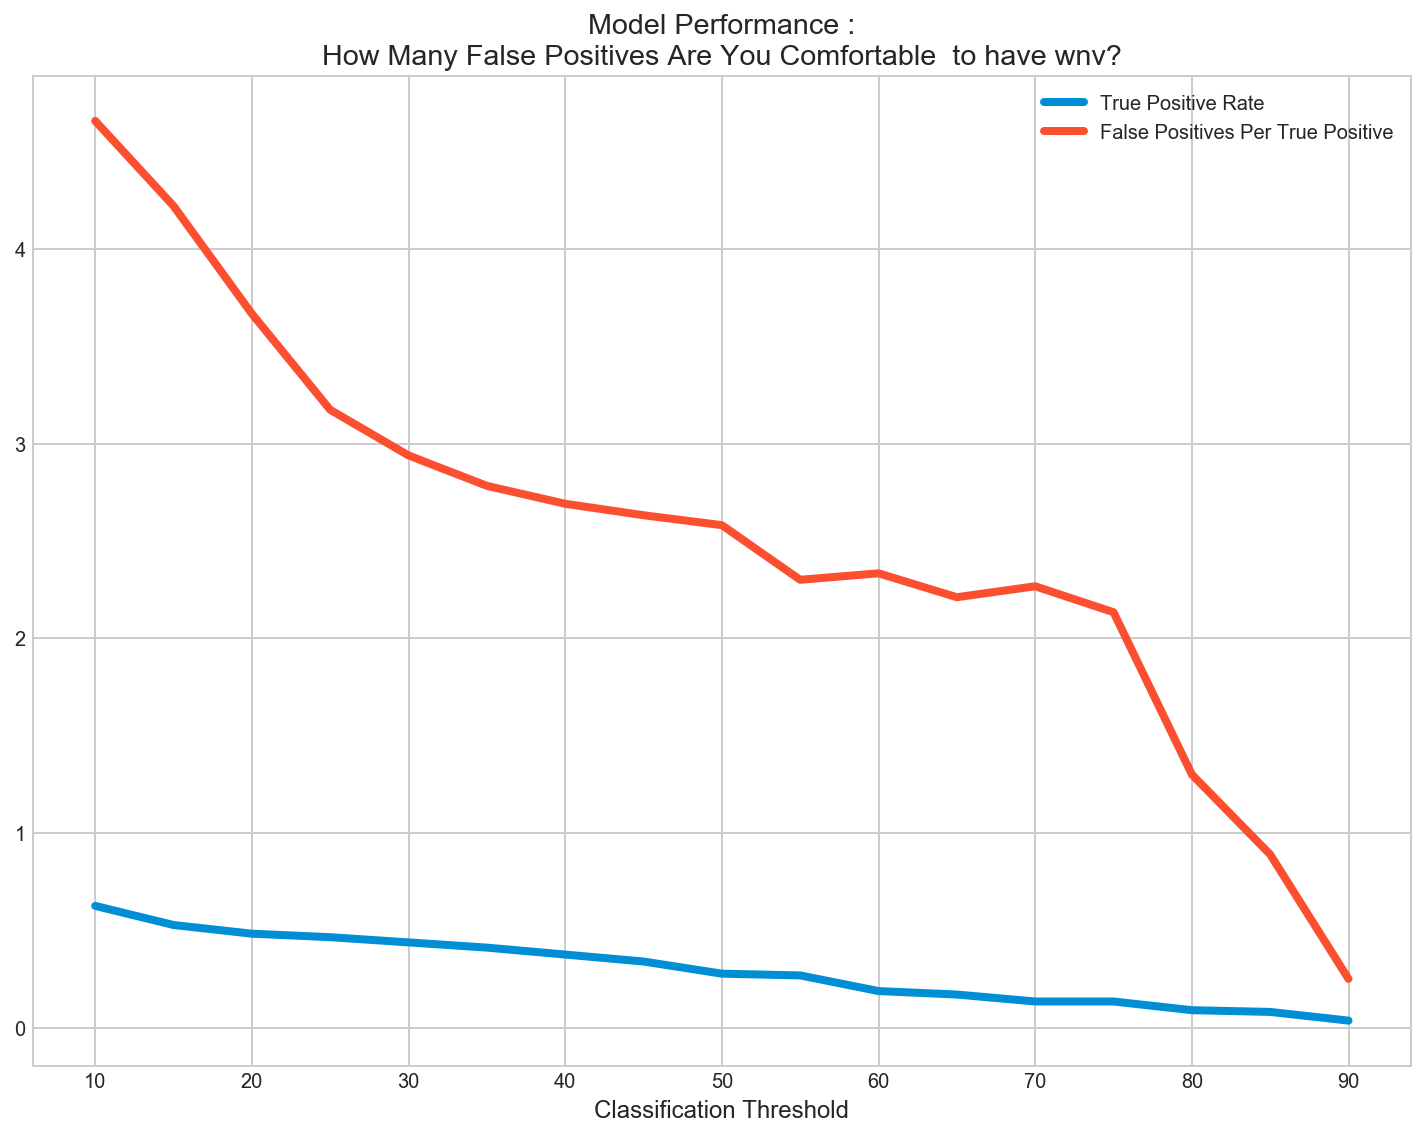

In [102]:
_ = Final_Model_Performance.plot()
_ = plt.title('Model Performance :\nHow Many False Positives Are You Comfortable  to have wnv?')
_ = plt.xlabel('Classification Threshold')

##### Logistic Regression

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
 

logreg = LogisticRegression()

log_pipe = Pipeline([ 
    ('log',logreg), 
])

log_pipe.fit(X_train, y_train)
print(log_pipe.score(X_train,y_train))
print(log_pipe.score(X_test,y_test))

0.9466920514040933
0.9467174119885823


In [104]:
from sklearn.metrics import confusion_matrix

y_pred = log_pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

tn: 1990, fp: 0, fn: 112, tp: 0


##### KNN

In [105]:
# knn takes forever

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()

knn_c_pipe = Pipeline([ 
    ('knn',knn), 
])
knn_c_pipe.fit(X_train, y_train)
knn_c_pipe.score(X_test, y_test)

0.9429115128449096

In [107]:
knn_c_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'knn', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])

##### Decision Tree Classifier

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dt_c = DecisionTreeClassifier(max_depth=5)


params = {
    'max_depth':[1, 2, 3, 5, 7, 10],
    'max_features':[1, 2,  3, 5]
}


gs_dt = GridSearchCV(estimator = dt_c, param_grid = params)
gs_dt.fit(X_train, y_train)
print(gs_dt.best_score_)
print(gs_dt.best_params_)

0.9466920514040933
{'max_depth': 1, 'max_features': 1}


In [110]:
dt_c.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [112]:
y_pred = gs_dt.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

tn: 1990, fp: 0, fn: 112, tp: 0


##### Random Forest Classifier

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rf_c = RandomForestClassifier()


params = {
    'n_estimators': [3,5,7,10], 
    'max_features': [3, 5, 7],
    'max_depth': [1, 2 , 3, 4]
}
gs_rf = GridSearchCV(rf_c, param_grid=params)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.9466920514040933
{'max_depth': 1, 'max_features': 3, 'n_estimators': 3}


In [114]:
rf_c.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [115]:
y_pred = gs_rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

tn: 1990, fp: 0, fn: 112, tp: 0


In [ ]:
# sample_submission = pd.read_csv('./assets/sampleSubmission.csv')
# sample_submission['WnvPresent'] = predictions
# sample_submission.to_csv('submission_randomforest.csv', index=False)

##### AdaBoost

In [116]:
from sklearn.ensemble import AdaBoostClassifier
ada_r = AdaBoostClassifier()

params = {
    'n_estimators':range(1,7)
}
gs_ada = GridSearchCV(ada_r, param_grid = params)
gs_ada.fit(X_train, y_train)
print(gs_ada.best_score_)
print(gs_ada.best_params_)

0.9466920514040933
{'n_estimators': 1}


In [117]:
gs_ada.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__algorithm', 'estimator__base_estimator', 'estimator__learning_rate', 'estimator__n_estimators', 'estimator__random_state', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [118]:
y_pred = gs_ada.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

tn: 1990, fp: 0, fn: 112, tp: 0


#### Support Vector Classifier

In [119]:
from sklearn.svm import SVC
clf_c = SVC(kernel='linear')

clf_c_pipe = Pipeline([ 
    ('clf',clf_c), 
])

clf_c_pipe.fit(X_train, y_train)
print(clf_c_pipe.score(X_test, y_test))

0.9467174119885823


In [120]:
clf_c_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'clf', 'clf__C', 'clf__cache_size', 'clf__class_weight', 'clf__coef0', 'clf__decision_function_shape', 'clf__degree', 'clf__gamma', 'clf__kernel', 'clf__max_iter', 'clf__probability', 'clf__random_state', 'clf__shrinking', 'clf__tol', 'clf__verbose'])

In [121]:
y_pred = clf_c_pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

tn: 1990, fp: 0, fn: 112, tp: 0


##### CNN

In [122]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [123]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [124]:
from keras import regularizers
import numpy as np
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(42)

model= Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = 1

model.add(Dense(n_hidden, input_dim=n_input, activation='relu'))
model.add(Dense(n_output, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
                metrics=['acc'])

#early_stop = EarlyStopping(monitor='val_loss', min_delta=0) 


history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                      epochs=30, batch_size=None)
                     # callbacks=[early_stop])

Train on 6303 samples, validate on 2102 samples
Epoch 1/30
6303/6303 [==============================] - 1s 142us/step - loss: 0.4609 - acc: 0.8068 - val_loss: 0.2609 - val_acc: 0.9467
Epoch 2/30
6303/6303 [==============================] - 1s 96us/step - loss: 0.2176 - acc: 0.9467 - val_loss: 0.2002 - val_acc: 0.9467
Epoch 3/30
6303/6303 [==============================] - 1s 98us/step - loss: 0.1893 - acc: 0.9467 - val_loss: 0.1878 - val_acc: 0.9467
Epoch 4/30
6303/6303 [==============================] - 1s 94us/step - loss: 0.1819 - acc: 0.9467 - val_loss: 0.1825 - val_acc: 0.9467
Epoch 5/30
6303/6303 [==============================] - 1s 97us/step - loss: 0.1782 - acc: 0.9467 - val_loss: 0.1790 - val_acc: 0.9467
Epoch 6/30
6303/6303 [==============================] - 1s 91us/step - loss: 0.1757 - acc: 0.9469 - val_loss: 0.1770 - val_acc: 0.9467
Epoch 7/30
6303/6303 [==============================] - 1s 93us/step - loss: 0.1742 - acc: 0.9472 - val_loss: 0.1750 - val_acc: 0.9467
Epoch 

/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


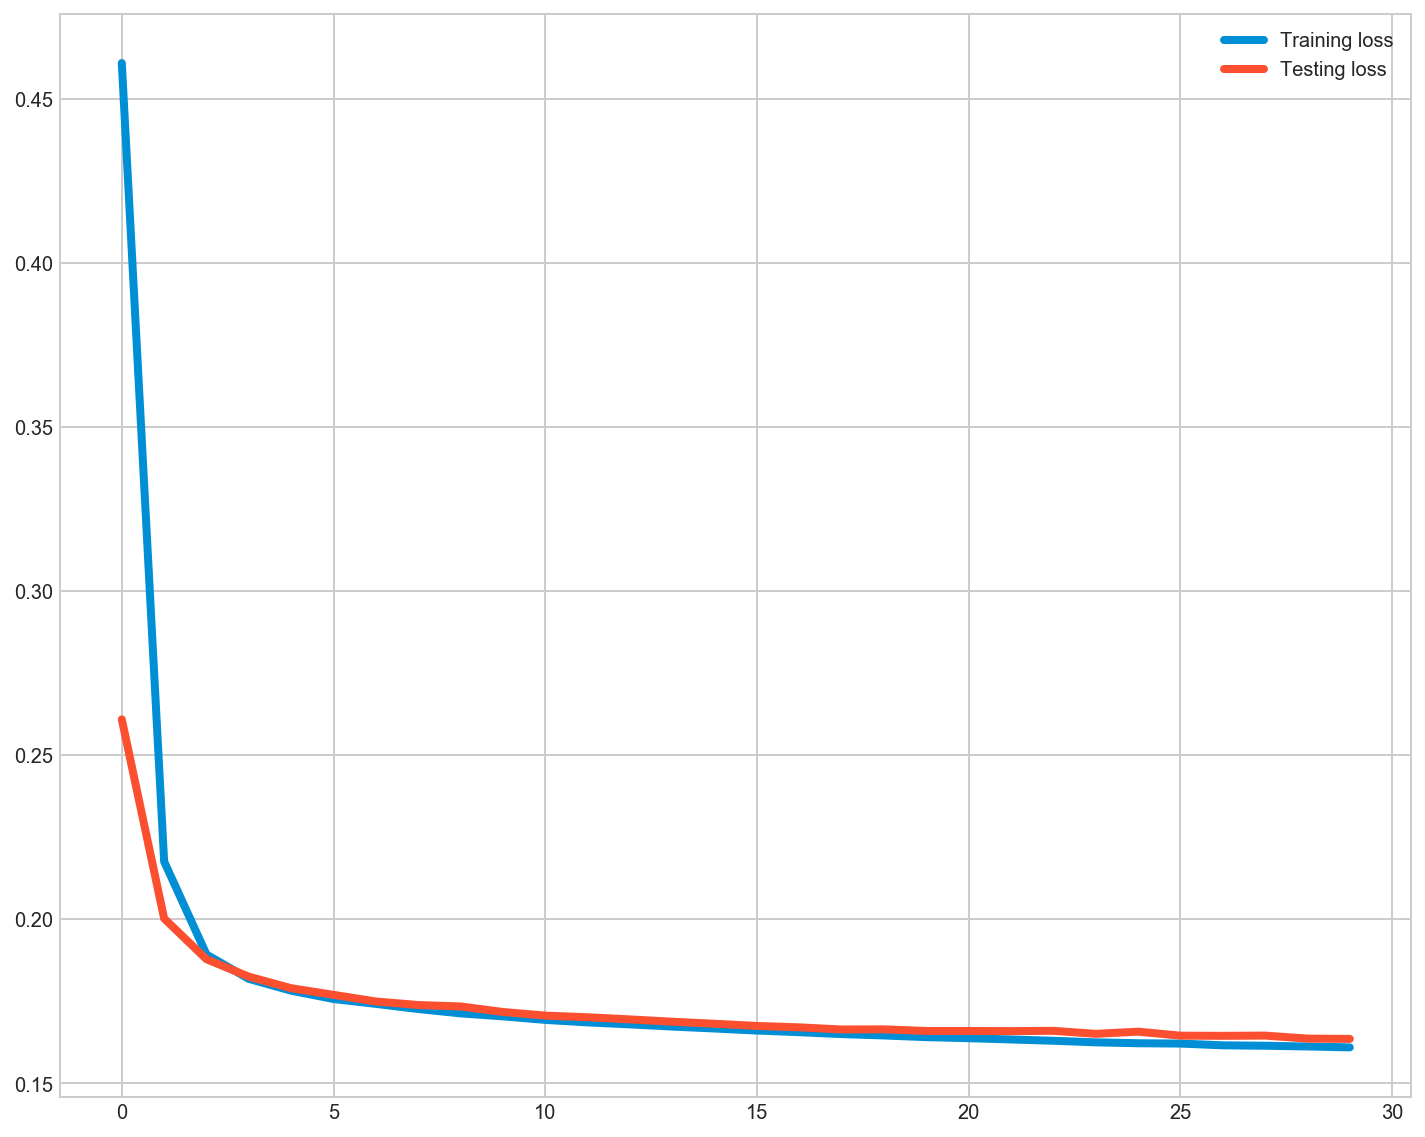

In [125]:
train_loss_2 = history.history['loss']
test_loss_2 = history.history['val_loss']
plt.plot(train_loss_2, label='Training loss')
plt.plot(test_loss_2, label='Testing loss')
plt.legend()

##### MODEL EVALUATION

In [128]:
from sklearn.metrics import confusion_matrix

def evaluate (X_test, y_test, model):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

In [129]:
models = [logreg, gs_dt, gs_rf, gs_ada, clf_c_pipe]
for model in models:
    print (evaluate (X_test, y_test, model))

tn: 738, fp: 1252, fn: 9, tp: 103
tn: 1990, fp: 0, fn: 112, tp: 0
tn: 1990, fp: 0, fn: 112, tp: 0
tn: 1990, fp: 0, fn: 112, tp: 0
tn: 1990, fp: 0, fn: 112, tp: 0


####  Final words 


The training scores and Kaggle submission scores correlated fairly well, although the Kaggle submission score usually about a tenth of a point lower. This is an indication that model results probably have some validity. Possible ways of improving the model: include features for cumulative weather conditions; these could include average temperature over the past week, average precipitation over the past week, and number of days without preciptiation.